In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.getcwd()

'/content'

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [8]:
path = '/content/drive/MyDrive/DSL/[세션] 정규세션/[0804] supervised learning'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
os.chdir(path)  # chdir: 경로 변경

In [9]:
os.getcwd()

'/content/drive/MyDrive/DSL/[세션] 정규세션/[0804] supervised learning'

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [146]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [147]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [148]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [149]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [150]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!
train_x

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0
...,...,...,...,...,...
83,23.9,2.8,68.0,0.0,0.6
84,25.0,3.1,63.0,0.0,0.8
85,26.0,3.1,60.0,0.0,1.0
86,26.4,3.8,60.0,0.0,1.0


In [152]:
train_y

0     8179.056
1     8135.640
2     8107.128
3     8048.808
4     8043.624
        ...   
83    8386.416
84    8435.664
85    8591.184
86    8638.488
87    8663.112
Name: Wh, Length: 88, dtype: float64

In [153]:
# train_df = train_x + train_y
train_df = pd.merge(train_x, train_y, left_index=True, right_index=True)
train_df

,Temp,Wind,Moisture,Precipitation,Sun,Wh
0,17.6,2.5,92.0,0.8,0.0,8179.056
1,17.7,2.9,91.0,0.3,0.0,8135.640
2,17.5,3.2,91.0,0.0,0.0,8107.128
3,17.1,3.2,91.0,0.0,0.0,8048.808
4,17.0,3.3,92.0,0.0,0.0,8043.624
...,...,...,...,...,...,...
83,23.9,2.8,68.0,0.0,0.6,8386.416
84,25.0,3.1,63.0,0.0,0.8,8435.664
85,26.0,3.1,60.0,0.0,1.0,8591.184
86,26.4,3.8,60.0,0.0,1.0,8638.488


In [154]:
# correlation
train_df.corr()

,Temp,Wind,Moisture,Precipitation,Sun,Wh
Temp,1.000000,0.510935,-0.628642,-0.173210,0.783829,0.803301
Wind,0.510935,1.000000,-0.478825,0.028617,0.544720,0.349288
Moisture,-0.628642,-0.478825,1.000000,0.152529,-0.699047,-0.095042
Precipitation,-0.173210,0.028617,0.152529,1.000000,-0.123846,-0.090389
Sun,0.783829,0.544720,-0.699047,-0.123846,1.000000,0.458348
Wh,0.803301,0.349288,-0.095042,-0.090389,0.458348,1.000000


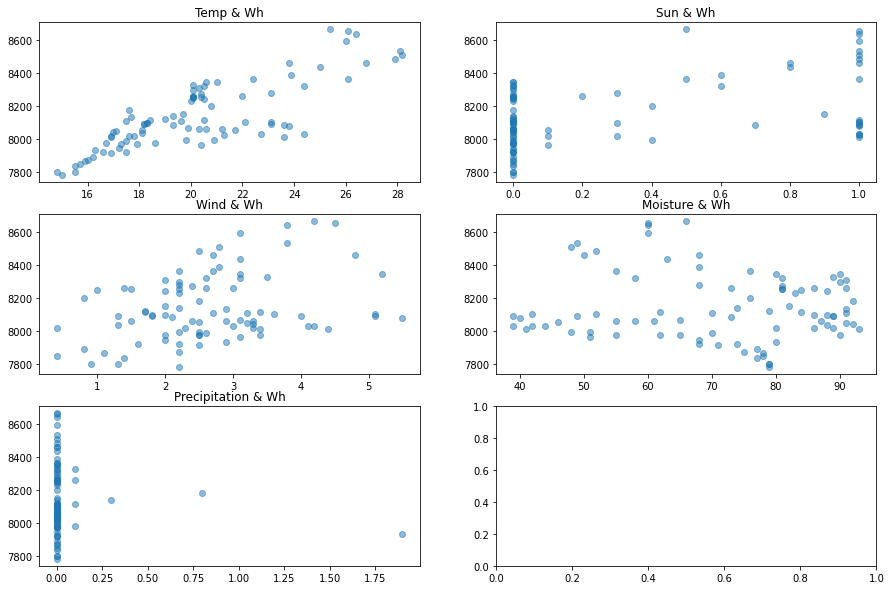

In [155]:
# scatter plot

fig, axes = plt.subplots(3, 2, figsize = (15, 10))

axes[0,0].scatter(train_df['Temp'], train_df['Wh'], alpha = 0.5)
axes[0,1].scatter(train_df['Sun'], train_df['Wh'], alpha = 0.5)
axes[1,0].scatter(train_df['Wind'], train_df['Wh'], alpha = 0.5)
axes[1,1].scatter(train_df['Moisture'], train_df['Wh'], alpha = 0.5)
axes[2,0].scatter(train_df['Precipitation'], train_df['Wh'], alpha = 0.5)

axes[0,0].set_title('Temp & Wh')
axes[0,1].set_title('Sun & Wh')
axes[1,0].set_title('Wind & Wh')
axes[1,1].set_title('Moisture & Wh')
axes[2,0].set_title('Precipitation & Wh')

plt.show()

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : 

> Correlation plot
- 종속변수(Wh)와의 상관계수 순위: Temp > Sun > Wind > Moisture > Precipitation

> Scatter plot
- Temp: 뚜렷한 선형 관계 관측 가능
- Sun: 양극화 양상 관측 가능
- Wind / Moisture: 상관관계 발견 어려움
- Precipitation: 0 이외의 값이 거의 없어 상관관계 파악이 어려움 <br>

=> Temp / Sun / Wind 변수 선택

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [156]:
# 사용할 패키지를 import!
from sklearn.preprocessing import MinMaxScaler

In [157]:
scaler = MinMaxScaler()
scaler.fit(train_df[['Temp', 'Sun', 'Wind']])
train_x = scaler.transform(train_df[['Temp', 'Sun', 'Wind']])

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [158]:
# 사용할 패키지를 import!
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [159]:
# Linear Regression
linear_model = LinearRegression().fit(train_x, train_y)
linear_esti_y = linear_model.predict(train_x)

In [160]:
# Polynomial Regression: 2차
polynomial_2 = PolynomialFeatures(2)
train_x_poly_2 = polynomial_2.fit_transform(train_x)
poly_2_model = LinearRegression().fit(train_x_poly_2, train_y)
poly_2_esti_y = poly_2_model.predict(train_x_poly_2)

In [161]:
# Polynomial Regression: 3차
polynomial_3 = PolynomialFeatures(3)
train_x_poly_3 = polynomial_3.fit_transform(train_x)
poly_3_model = LinearRegression().fit(train_x_poly_3, train_y)
poly_3_esti_y = poly_3_model.predict(train_x_poly_3)

In [162]:
# Polynomial Regression: 4차
polynomial_4 = PolynomialFeatures(4)
train_x_poly_4 = polynomial_4.fit_transform(train_x)
poly_4_model = LinearRegression().fit(train_x_poly_4, train_y)
poly_4_esti_y = poly_4_model.predict(train_x_poly_4)

In [163]:
# Ridge Regression
ridge_model = Ridge(random_state=123).fit(train_x_poly_2, train_y)
ridge_esti_y = ridge_model.predict(train_x_poly_2)

In [164]:
# Lasso Regression
lasso_model = Lasso(random_state=123).fit(train_x, train_y)
lasso_esti_y = lasso_model.predict(train_x) 

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [165]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [166]:
# train_y mse loss
print(f"Linear {mse(linear_esti_y, train_y):.5f}")
print(f"Polynomial_2 {mse(poly_2_esti_y, train_y):.5f}")
print(f"Polynomial_3 {mse(poly_3_esti_y, train_y):.5f}")
print(f"Polynomial_4 {mse(poly_4_esti_y, train_y):.5f}")
print(f"Ridge {mse(ridge_esti_y, train_y):.5f}")
print(f"Lasso {mse(lasso_esti_y, train_y):.5f}")

Linear 11423.02779
Polynomial_2 10340.38088
Polynomial_3 6465.33019
Polynomial_4 63938.12975
Ridge 11918.06813
Lasso 11523.08952


In [167]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

In [142]:
# train_x.shape가 (88, 3)이기 때문에 시각화 불가
# visualize(model, train_x, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [168]:
# transform
test_x = scaler.transform(test_x[['Temp', 'Sun', 'Wind']])
test_x_poly_2 = polynomial_2.fit_transform(test_x)
test_x_poly_3 = polynomial_3.fit_transform(test_x)
test_x_poly_4 = polynomial_4.fit_transform(test_x)

In [171]:
# predict값 할당
linear_pred_y = linear_model.predict(test_x)
poly_2_pred_y = poly_2_model.predict(test_x_poly_2)
poly_3_pred_y = poly_3_model.predict(test_x_poly_3)
poly_4_pred_y = poly_4_model.predict(test_x_poly_4)
ridge_pred_y = ridge_model.predict(test_x_poly_2)
lasso_pred_y = lasso_model.predict(test_x)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [53]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [176]:
# test_y mse loss
print(f"Linear {mse(linear_pred_y, test_y):.4f}")
print(f"Polynomial_2 {mse(poly_2_pred_y, test_y):.4f}")
print(f"Polynomial_3 {mse(poly_3_pred_y, test_y):.4f}")
print(f"Polynomial_4 {mse(poly_4_pred_y, test_y):.4f}")
print(f"Ridge {mse(ridge_pred_y, test_y):.4f}")
print(f"Lasso {mse(lasso_pred_y, test_y):.4f}")

Linear 141348.4478
Polynomial_2 161628.5946
Polynomial_3 319678.0660
Polynomial_4 2393397.8784
Ridge 182037.0914
Lasso 150024.5731


In [175]:
# score
print(f"Linear {mse(linear_pred_y, test_y)/mse(linear_esti_y, train_y):.4f}")
print(f"Polynomial_2 {mse(poly_2_pred_y, test_y)/mse(poly_2_esti_y, train_y):.4f}")
print(f"Polynomial_3 {mse(poly_3_pred_y, test_y)/mse(poly_3_esti_y, train_y):.4f}")
print(f"Polynomial_4 {mse(poly_4_pred_y, test_y)/mse(poly_4_esti_y, train_y):.4f}")
print(f"Ridge {mse(ridge_pred_y, test_y)/mse(ridge_esti_y, train_y):.4f}")
print(f"Lasso {mse(lasso_pred_y, test_y)/mse(lasso_esti_y, train_y):.4f}")

Linear 12.3740
Polynomial_2 15.6308
Polynomial_3 49.4450
Polynomial_4 37.4330
Ridge 15.2740
Lasso 13.0195


In [ ]:
# visualization 하실 분은 진행해주세요!
# visualize(model, test_x, test_y)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

- train_y의 mse / test_y의 mse / score을 비교해보았을 때, Temp / Sun / Wind를 독립변수로 사용하고 LinearRegression 알고리즘을 사용한 모델을 최적의 모델로 판단

고생하셨습니다!